<a href="https://colab.research.google.com/github/gav1ao/datascience/blob/main/bank_marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Classificação: Adesão a Produto Bancário
Este notebook faz parte do MVP da disciplina **Engenharia de Sistemas de Software Inteligentes**. O objetivo é prever se um cliente aceitará ou não uma oferta de depósito a prazo (term deposit), com base em dados de campanhas de marketing realizadas por uma instituição bancária.

## Dataset
O dataset utilizado é o **Bank Marketing Dataset** disponível publicamente no repositório da UCI Machine Learning Repository.
Fonte: https://archive.ics.uci.edu/dataset/222/bank+marketing


In [ ]:
# Instalação dos pacotes
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install seaborn

In [ ]:
# Imports
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## 1. Carregando o Dataset
Vamos carregar o dataset diretamente de uma URL pública no GitHub.


In [ ]:
url = "https://raw.githubusercontent.com/gav1ao/datascience/main/bank_marketing/bank.csv"
df = pd.read_csv(url, sep=';')
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


## 2. Entendimento e Análise Exploratória
Vamos verificar a estrutura, tipos de dados, estatísticas básicas e presença de valores ausentes.


In [ ]:
df.info()
print("\nValores únicos da variável alvo:")
print(df['y'].value_counts())

print("\nVerificando dados ausentes:")
print(df.isnull().sum())

print("\nEstatísticas das variáveis numéricas:")
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB

Valores únicos da variável alvo:
y
no     4000
yes     521
Name: count, dtype: int64

Verificando 

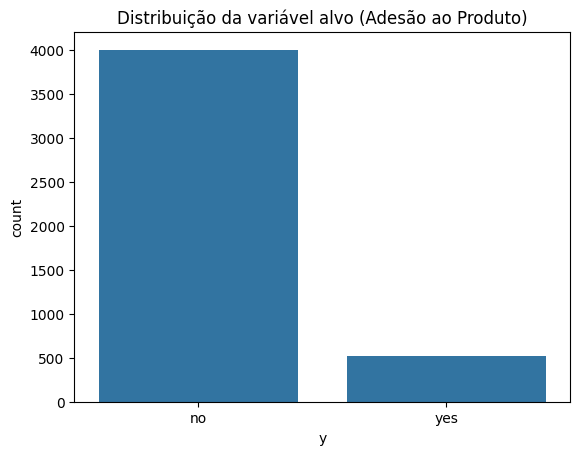

In [ ]:
# Visualização da variável alvo
sns.countplot(x='y', data=df)
plt.title("Distribuição da variável alvo (Adesão ao Produto)")
plt.show()


## 3. Pré-processamento dos Dados
Faremos:
- Separação entre variáveis numéricas e categóricas
- Codificação de variáveis categóricas (OneHotEncoder)
- Padronização de variáveis numéricas (StandardScaler)
- Separação entre treino e teste (70/30)


In [ ]:
# Separação de X e y
X = df.drop('y', axis=1)
y = df['y'].map({'yes': 1, 'no': 0})

# Seleção de colunas
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

# Pré-processadores
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Column Transformer
pre_processor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)


## 4. Modelagem e Avaliação
Vamos treinar 4 modelos:
- K-Nearest Neighbors (KNN)
- Árvore de Decisão
- Naive Bayes
- Support Vector Machine (SVM)

Usaremos `GridSearchCV` para otimizar hiperparâmetros e `cross_val_score` para avaliação.


In [ ]:
resultados = {}

def avaliar_modelo(nome, modelo, params):
    pipe = Pipeline(steps=[('preprocess', pre_processor), ('clf', modelo)])
    grid = GridSearchCV(pipe, param_grid=params, cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\nModelo: {nome}")
    print("Melhores hiperparâmetros:", grid.best_params_)
    print("Acurácia no teste:", acc)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))

    resultados[nome] = {
        'modelo': grid.best_estimator_,
        'acuracia': acc,
        'relatorio': classification_report(y_test, y_pred, output_dict=True)
    }


### KNN


In [ ]:
avaliar_modelo("knn", KNeighborsClassifier(), {
    'clf__n_neighbors': [3, 5, 7],
    'clf__weights': ['uniform', 'distance']
})



Modelo: knn
Melhores hiperparâmetros: {'clf__n_neighbors': 7, 'clf__weights': 'distance'}
Acurácia no teste: 0.8865143699336773
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      1201
           1       0.52      0.16      0.25       156

    accuracy                           0.89      1357
   macro avg       0.71      0.57      0.59      1357
weighted avg       0.86      0.89      0.86      1357

Matriz de Confusão:
 [[1178   23]
 [ 131   25]]


### Árvore de Decisão


In [ ]:
avaliar_modelo("decision_tree", DecisionTreeClassifier(random_state=42), {
    'clf__max_depth': [5, 10, 20, None],
    'clf__min_samples_split': [2, 5, 10]
})



Modelo: decision_tree
Melhores hiperparâmetros: {'clf__max_depth': 5, 'clf__min_samples_split': 5}
Acurácia no teste: 0.8916728076639646
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      1201
           1       0.55      0.33      0.41       156

    accuracy                           0.89      1357
   macro avg       0.73      0.65      0.68      1357
weighted avg       0.88      0.89      0.88      1357

Matriz de Confusão:
 [[1158   43]
 [ 104   52]]


### Naive Bayes


In [ ]:
avaliar_modelo("naive_bayes", GaussianNB(), {})  # Não tem hiperparâmetros a ajustar



Modelo: naive_bayes
Melhores hiperparâmetros: {}
Acurácia no teste: 0.8179808400884304
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89      1201
           1       0.29      0.41      0.34       156

    accuracy                           0.82      1357
   macro avg       0.61      0.64      0.62      1357
weighted avg       0.85      0.82      0.83      1357

Matriz de Confusão:
 [[1046  155]
 [  92   64]]


### SVM


In [ ]:
avaliar_modelo("svm", SVC(), {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf']
})



Modelo: svm
Melhores hiperparâmetros: {'clf__C': 1, 'clf__kernel': 'rbf'}
Acurácia no teste: 0.89240972733972
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      1201
           1       0.60      0.19      0.28       156

    accuracy                           0.89      1357
   macro avg       0.75      0.59      0.61      1357
weighted avg       0.87      0.89      0.87      1357

Matriz de Confusão:
 [[1182   19]
 [ 127   29]]


## 5. Comparação de Resultados


In [ ]:
df_resultados = pd.DataFrame({
    modelo: [resultados[modelo]['acuracia']] for modelo in resultados
}, index=['Acurácia']).T

df_resultados.sort_values(by='Acurácia', ascending=False)


,Acurácia
svm,0.892410
decision_tree,0.891673
knn,0.886514
naive_bayes,0.817981


## 6. Exportação de dados para testes posteriores
Agora, vamos exportar os dados necessários, assim como os modelos, para testes posteriores.


In [ ]:
os.makedirs('models', exist_ok=True)

# Exporta os modelos
for nome, dados in resultados.items():
    modelo = dados['modelo']

    with open(f'./models/model_{nome}.pkl', 'wb') as f:
        pickle.dump(modelo, f)

# Salvando X_test e y_test
os.makedirs('data', exist_ok=True)
X_test_df = pd.DataFrame(X_test, columns=df.columns[:-1])
y_test_df = pd.DataFrame(y_test, columns=[df.columns[-1]])
X_test_df.to_csv("data/X_test_dataset.csv", index=False)
y_test_df.to_csv("data/y_test_dataset.csv", index=False)

## 7. Exportação do Melhor Modelo
Vamos exportar o melhor modelo entre os testados.


In [ ]:
modelo_com_melhor_acuracia = max(resultados.items(), key=lambda x: x[1]['acuracia'])
melhor_modelo = modelo_com_melhor_acuracia[1]['modelo']

model_filename = 'melhor_modelo.pkl'
with open("./models/"+model_filename, 'wb') as file:
    pickle.dump(melhor_modelo, file)

model = SVC()
pipeline = Pipeline(steps=[('preprocess', pre_processor), ('clf', model)])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(accuracy_score(y_test, predictions))

os.makedirs('pipelines', exist_ok=True)
pipeline_filename = 'modelo_bancario_pipeline.pkl'
with open("./pipelines/"+pipeline_filename, 'wb') as file:
    pickle.dump(pipeline, file)

0.89240972733972


## 8. Conclusão

Neste trabalho, exploramos um problema de classificação baseado em campanhas de marketing de um banco, com o objetivo de prever se um cliente aceitaria ou não uma oferta de depósito a prazo.

**Principais etapas:**
- Carga e entendimento do dataset real
- Análise exploratória e preparação dos dados
- Comparação entre 4 algoritmos de classificação
- Escolha do melhor modelo com base em desempenho
- Exportação do modelo para uso futuro

**Modelo com melhor desempenho:**
- SVM: 0.892410 (Acurácia)

Por fim, esse modelo será usado em uma aplicação fullstack que permitirá avaliação de outros cenários.
